<a href="https://colab.research.google.com/github/vijaynadimpalli/dlaicourse/blob/master/TensorFlow%20In%20Practice/Course%204%20-%20S%2BP/S%2BP%20Week%204%20Exercise%20Question.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
!pip install tensorflow-gpu==2.0.0

     |████████████████████████████████| 380.8MB 43kB/s 
     |████████████████████████████████| 3.8MB 58.3MB/s 
     |████████████████████████████████| 51kB 8.3MB/s 
     |████████████████████████████████| 450kB 61.5MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=716d91c98ce909480b504a686d18a5e1fbec6a7ec871ee45322f88b875084e70
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.3.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorflow-estimator<2.4.0,>=2.3.0, but you'll have tensorflow-estimator 2.0.1 which is incompatible.
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing ins

In [3]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [4]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [5]:
!wget --no-check-certificate \
    https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv \
    -O /tmp/daily-min-temperatures.csv

--2020-09-30 17:23:55--  https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 67921 (66K) [text/plain]
Saving to: ‘/tmp/daily-min-temperatures.csv’

/tmp/daily-min-temp 100%[===================>]  66.33K  --.-KB/s    in 0.01s   

2020-09-30 17:23:55 (4.53 MB/s) - ‘/tmp/daily-min-temperatures.csv’ saved [67921/67921]



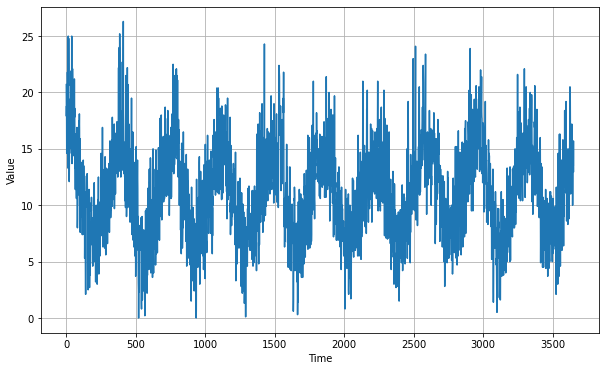

In [6]:
import csv
time_step = []
temps = []

with open('/tmp/daily-min-temperatures.csv') as csvfile:
  reader = csv.reader(csvfile)
  next(reader)  
  for ind,line in enumerate(reader):
    temps.append(np.array(line[1],dtype='float32'))
    time_step.append(ind + 1)
# YOUR CODE HERE. READ TEMPERATURES INTO TEMPS
# HAVE TIME STEPS BE A SIMPLE ARRAY OF 1, 2, 3, 4 etc

series = np.array(temps)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [7]:
split_time = 2500
time_train = time[:split_time] # YOUR CODE HERE
x_train = series[:split_time] # YOUR CODE HERE
time_valid = time[split_time:] # YOUR CODE HERE
x_valid = series[split_time:] # YOUR CODE HERE

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000


In [8]:
#tf.data.Dataset.map()

In [9]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    win = tf.data.Dataset.from_tensor_slices(series)
    win = win.window(window_size + 1,shift=1,drop_remainder=True)
    win = win.flat_map(lambda x : x.batch(window_size + 1))
    win = win.shuffle(shuffle_buffer)
    win = win.map(lambda x : (x[:-1],x[1:]))
    win = win.batch(batch_size).prefetch(1)
    return win

In [10]:
#data = windowed_dataset(np.arange(0,100,1),window_size,batch_size,shuffle_buffer_size)

In [11]:
# for x in data:
#   print(x)

In [12]:
def model_forecast(model, series, window_size):
    win = tf.data.Dataset.from_tensor_slices(series)
    win = win.window(window_size,shift=1,drop_remainder=True)
    win = win.flat_map(lambda x : x.batch(window_size))
    win = win.batch(32).prefetch(1)
    out = model.predict(win)
    return out

In [13]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x : tf.expand_dims(x,axis=-1),input_shape=[None]),
    tf.keras.layers.Conv1D(64,5,padding='causal',activation='relu'),
    tf.keras.layers.LSTM(100,return_sequences=True),
    tf.keras.layers.LSTM(100,return_sequences=True),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100.0)
])

print(model.summary())

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None), (None, None)), types: (tf.float32, tf.float32)>
(2500,)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 64)          384       
_________________________________________________________________
lstm (LSTM)                  (None, None, 100)         66000     
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 100)         80400     
_________________________________________________________________
dense (Dense)                (None, None, 100)         10100     
_________________________________________________________________
dense_1 (Dense)              (None, None, 10)          1010      
__________________________

(1e-08, 0.0001, 0.0, 60.0)

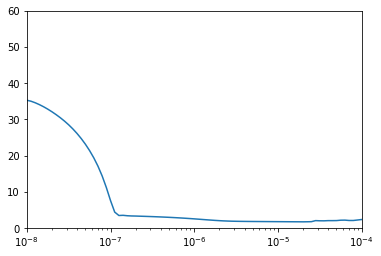

In [14]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [18]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x : tf.expand_dims(x,axis=-1),input_shape=[None]),
    tf.keras.layers.Conv1D(64,5,padding='causal',activation='relu'),
    tf.keras.layers.LSTM(100,return_sequences=True),
    tf.keras.layers.LSTM(100,return_sequences=True),
    #tf.keras.layers.Dense(100,activation='relu'),
    #tf.keras.layers.Dense(10,activation='relu'),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x*100.0)
])


optimizer = tf.keras.optimizers.SGD(lr=2*1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=40)
                                    
# EXPECTED OUTPUT SHOULD SEE AN MAE OF <2 WITHIN ABOUT 30 EPOCHS

Epoch 1/40
25/25 [==============================] - 3s 130ms/step - loss: 3.3256 - mae: 3.8132
Epoch 2/40
25/25 [==============================] - 1s 23ms/step - loss: 2.1493 - mae: 2.6017
Epoch 3/40
25/25 [==============================] - 1s 21ms/step - loss: 1.9009 - mae: 2.3543
Epoch 4/40
25/25 [==============================] - 1s 21ms/step - loss: 1.8059 - mae: 2.2571
Epoch 5/40
25/25 [==============================] - 1s 22ms/step - loss: 1.7898 - mae: 2.2385
Epoch 6/40
25/25 [==============================] - 1s 22ms/step - loss: 1.7346 - mae: 2.1816
Epoch 7/40
25/25 [==============================] - 1s 21ms/step - loss: 1.7151 - mae: 2.1621
Epoch 8/40
25/25 [==============================] - 1s 22ms/step - loss: 1.6937 - mae: 2.1390
Epoch 9/40
25/25 [==============================] - 1s 21ms/step - loss: 1.6711 - mae: 2.1148
Epoch 10/40
25/25 [==============================] - 1s 21ms/step - loss: 1.7229 - mae: 2.1690
Epoch 11/40
25/25 [==============================] - 1s 21

In [19]:
rnn_forecast = model_forecast(model, series[...], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

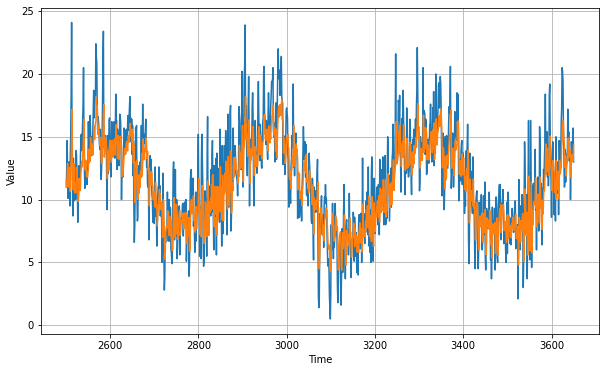

In [20]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

# EXPECTED OUTPUT. PLOT SHOULD SHOW PROJECTIONS FOLLOWING ORIGINAL DATA CLOSELY

In [21]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

# EXPECTED OUTPUT MAE < 2 -- I GOT 1.789626

1.8388139

In [22]:
print(rnn_forecast)
# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[11.54097   10.9720125 11.8668585 ... 13.024935  13.161606  14.351079 ]
